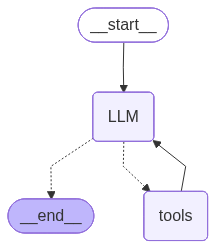

In [17]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
# from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import AzureChatOpenAI
import operator
from dotenv import load_dotenv
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage, AIMessage
import uuid
# from langchain_community.tools import DuckDuckGoSearchRun
import sqlite3
from langchain.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()


class chatbot(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

# search_tool = DuckDuckGoSearchRun(region="us-en")

@tool 
def add_two_numbers(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b

@tool
def multiply_two_numbers(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

def generate_thread_id():
    """Generate a new unique thread id using uuid4."""
    return str(uuid.uuid4())

def list_threads():
    """Return a list of all thread ids from the checkpointer memory."""
    return {
        checkpoint.config['configurable']['thread_id']
        for checkpoint in checkpointer.list(config=None)
        if "thread_id" in checkpoint.config['configurable']
    }

def get_thread_messages(thread_id: str):
    """Return the state for a given thread id from the compiled graph."""
    config = {"configurable": {"thread_id": thread_id}}
    thread_messages = []
   
    if 'messages' in g.get_state(config=config).values:
        for message in g.get_state(config=config).values['messages']:
            if isinstance(message, HumanMessage):
                thread_messages.append({"role": "human", "content": message.content})
            elif isinstance(message, AIMessage):
                thread_messages.append({"role": "ai", "content": message.content})
    return thread_messages


llm = AzureChatOpenAI(
    azure_deployment="o4-mini",
    api_version="2024-12-01-preview"
)

llm_wth_tools = llm.bind_tools([ add_two_numbers, multiply_two_numbers])    

def LLM(state: chatbot) -> chatbot:
    response = llm_wth_tools.invoke(state["messages"])
    return {"messages": [AIMessage(response.content)]}

graph = StateGraph(chatbot)
graph.add_node("LLM", LLM)
graph.add_edge(START, "LLM")
tools = ToolNode(tools=[ add_two_numbers, multiply_two_numbers])
graph.add_node("tools", tools)

graph.add_conditional_edges("LLM", tools_condition, {"tools", END})
graph.add_edge("tools", "LLM")

# conn = sqlite3.connect(database='chatbot.db', check_same_thread=False)
# checkpointer = SqliteSaver(conn=conn)
g = graph.compile()
g
# png_bytes = g.get_graph(xray=True).draw_mermaid_png()
# with open("agent.png", "wb") as f:
#     f.write(png_bytes)
# print("Saved agent.png")
# config = {"configurable": {"thread_id": "1"}}
# display(Image(g.get_graph(xray=True).draw_mermaid_png()))

# g.invoke({"messages": [HumanMessage("hi")]}, config=config)
# config = {"configurable": {"thread_id": "2"}}
# g.invoke({"messages" :[HumanMessage("what is my name")]}, config=config)
# print([checkpoint.config['configurable']['thread_id'] for checkpoint in checkpointer.list(config=None)])